Primero debemos preparar las imagenes categorizadas en dos carpetas 1 y 0 para poder entrenar el modelo.

In [ ]:
!pip install keras-tuner
!pip install scikit-plot
!pip install tarfile #Para crear el TAR

     |████████████████████████████████| 98 kB 3.5 MB/s 
ERROR: Could not find a version that satisfies the requirement tarfile (from versions: none)
ERROR: No matching distribution found for tarfile


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

import pathlib
import numpy as np
import pandas as pd

import tarfile #TAR file
import os.path

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# Cargamos Dataset usado por Nacho para ML - Conexion Drive 
# Importar drive y pandas
from google.colab import drive
drive.mount('/content/drive')

project_id = 'angelic-cat-338018'
!gcloud config set project {project_id}

#Conexion Cloud
from google.colab import auth
auth.authenticate_user()

Mounted at /content/drive
Updated property [core/project].


In [ ]:
img_height = 128
img_width = 128
batch_size = 32 # opcion 2

# Data Cleaning & Data Engineering

In [ ]:
#Partimos del TAR creado para la categorizacion de productos, donde tenemos las fotos divididas en carpetas por categorias.
dataset_url = "https://storage.googleapis.com/tfmbucket1/images/train/Dataset.tar"
data_dir = tf.keras.utils.get_file('Dataset', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

3268132864/3268118016 [==============================] - 33s 0us/step


El repositorio de imagenes contiene:  612646  elementos


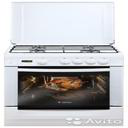

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print("El repositorio de imagenes contiene: ", image_count, " elementos")

appliances = list(data_dir.glob('Appliances/*'))
PIL.Image.open(str(appliances[0]))

612646  imagenes tenemos

In [ ]:
#Train
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 612646 files belonging to 14 classes.
Using 490117 files for training.


In [ ]:
#Test
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 612646 files belonging to 14 classes.
Using 122529 files for validation.


In [ ]:
#Cogemos el dataset donde tenemos los datos y las referencias de las fotos
directorio_dataset = '/content/drive/MyDrive/TFM Big Data & BA/Propuestas/Proyecto Final/0 - Dataset/train_data.csv'
df = pd.read_csv(directorio_dataset)

In [ ]:
#!rm -rf /content/Dataset   Eliminar carpeta de drive temporal en este colab

In [ ]:
#Funcion para procesar las 612646 imagenes de una tirada y clasificarlas en 0 y 1
#Tarda unas 6 horas, hay riesgo de que colab se cierre, por lo que se ha hecho por paquetes

i = 1
import os
!mkdir /content/Dataset
!mkdir /content/Dataset/0
!mkdir /content/Dataset/1

dataset_url = "https://storage.googleapis.com/tfmbucket1/images/train/Dataset.tar"
data_dir = tf.keras.utils.get_file('Dataset', origin=dataset_url, untar=True)
#data_dir = pathlib.Path(data_dir)
for folder in os.listdir(data_dir):
  fldir = data_dir + "/" + folder
  print(fldir)
  for image in os.listdir(fldir):
      imgdir = fldir + '/' + image
      value = df[df['image']== image[0:-4] ]['sold'].values[0]
      os.rename(imgdir,  "/content/Dataset/" + value.astype(str) + "/" + image)
      i = i + 1
      if (i % 10000) == 0:
        print(i)

In [ ]:
#Creamos el TAR con los archivos temporales del Colab
def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))

make_tarfile("/content/Dataset_bin.tar", "/content/Dataset")

In [ ]:
#Subimos el TAR a google cloud
!gsutil cp -r /content/Dataset_bin.tar gs://tfmbucket1/images/train

# Modelo: Modelo de churn

In [ ]:
img_height = 128
img_width = 128 
batch_size = 64 # opcion 2

dataset_url = "https://storage.googleapis.com/tfmbucket1/images/train/Dataset_bin.tar" # Nueva ruta
data_dir = tf.keras.utils.get_file('Dataset_bin', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("El repositorio de imagenes contiene: ", image_count, " elementos")

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

2799452160/2799437824 [==============================] - 33s 0us/step
El repositorio de imagenes contiene:  591659  elementos
Found 591659 files belonging to 2 classes.
Using 473328 files for training.
Found 591659 files belonging to 2 classes.
Using 118331 files for validation.


In [ ]:
# Number of training examples and labels
num_train = tf.data.experimental.cardinality(train_ds).numpy() * batch_size
num_validation = tf.data.experimental.cardinality(val_ds).numpy() * batch_size
num_classes =  2
num_iterations = int(tf.data.experimental.cardinality(train_ds).numpy()) 

In [ ]:
def normalize_img(image, label, img_size):
    # Resize image to the desired img_size and normalize it
    # One hot encode the label
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    label = label #tf.one_hot(label, depth=num_classes) No haria falta onehot no??
    return image, label
    
def preprocess_data(train, validation, batch_size, img_size):
    # Apply the normalize_img function on all train and validation data and create batches
    train_processed = train.map(lambda image, label: normalize_img(image, label, img_size))
    
    # If your data is already batched (eg, when using the image_dataset_from_directory function), remove .batch(batch_size)
    train_processed = train_processed.repeat()
    
    validation_processed = validation.map(lambda image, label: normalize_img(image, label, img_size))
    
    # If your data is already batched (eg, when using the image_dataset_from_directory function), remove .batch(batch_size)
    validation_processed = validation_processed
    
    return train_processed, validation_processed
    
# Run preprocessing
train_processed_224, validation_processed_224 = preprocess_data(train_ds, val_ds, batch_size, img_size=[224,224])
train_processed_331, validation_processed_331 = preprocess_data(train_ds, val_ds, batch_size, img_size=[331,331])

In [ ]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm

# Set batch size for training and validation

def corrermodelo_bin(model_name, model):
 # for model_name, model in attrib:
      # Special handling for "NASNetLarge" since it requires input images with size (331,331)
      if 'NASNetLarge' in model_name:
          input_shape=(331,331,3)
          train_processed = train_processed_331
          validation_processed = validation_processed_331
      else:
          input_shape=(224,224,3)
          train_processed = train_processed_224
          validation_processed = validation_processed_224
          
      # load the pre-trained model with global average pooling as the last layer and freeze the model weights
      pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
      pre_trained_model.trainable = False
      
      # custom modifications on top of pre-trained model and fit
      clf_model = tf.keras.models.Sequential()
      clf_model.add(pre_trained_model)
      clf_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
      clf_model.compile(loss='binary_crossentropy', metrics=['accuracy'])
      history = clf_model.fit(train_processed, epochs = 3, validation_data=validation_processed, steps_per_epoch=num_iterations)
      
      # Calculate all relevant metrics
      model_benchmarks['model_name'].append(model_name)
      model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
      model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])

      clf_model.save('/content/Churnmodel_' + model_name, save_format = 'h5')
      !gsutil cp -r /content/Churnmodel_{model_name} gs://tfmbucket1/models


In [ ]:
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

In [ ]:
keys_list = list(model_dictionary)
values = list(model_dictionary.values())
model_dictionary

{'DenseNet121': <function keras.applications.densenet.DenseNet121>,
 'DenseNet169': <function keras.applications.densenet.DenseNet169>,
 'DenseNet201': <function keras.applications.densenet.DenseNet201>,
 'EfficientNetB0': <function keras.applications.efficientnet.EfficientNetB0>,
 'EfficientNetB1': <function keras.applications.efficientnet.EfficientNetB1>,
 'EfficientNetB2': <function keras.applications.efficientnet.EfficientNetB2>,
 'EfficientNetB3': <function keras.applications.efficientnet.EfficientNetB3>,
 'EfficientNetB4': <function keras.applications.efficientnet.EfficientNetB4>,
 'EfficientNetB5': <function keras.applications.efficientnet.EfficientNetB5>,
 'EfficientNetB6': <function keras.applications.efficientnet.EfficientNetB6>,
 'EfficientNetB7': <function keras.applications.efficientnet.EfficientNetB7>,
 'InceptionResNetV2': <function keras.applications.inception_resnet_v2.InceptionResNetV2>,
 'InceptionV3': <function keras.applications.inception_v3.InceptionV3>,
 'MobileN

In [ ]:
corrermodelo_bin(keys_list[0], values[0]) #DenseNet121
print("Hecho")

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/3
7396/7396 [==============================] - 1878s 253ms/step - loss: 0.6113 - accuracy: 0.6780 - val_loss: 0.6150 - val_accuracy: 0.6777
Epoch 2/3
7396/7396 [==============================] - 1875s 253ms/step - loss: 0.6076 - accuracy: 0.6811 - val_loss: 0.6017 - val_accuracy: 0.6852
Epoch 3/3
7396/7396 [==============================] - 1873s 253ms/step - loss: 0.6074 - accuracy: 0.6810 - val_loss: 0.6220 - val_accuracy: 0.6627
CommandException: No URLs matched: /content/DenseNet121
Hecho


In [ ]:
corrermodelo_bin(keys_list[2], values[2]) #DenseNet201
print("Hecho")

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/3
7396/7396 [==============================] - 2976s 399ms/step - loss: 0.6109 - accuracy: 0.6790 - val_loss: 0.6050 - val_accuracy: 0.6831
Epoch 2/3
7396/7396 [==============================] - 2871s 388ms/step - loss: 0.6083 - accuracy: 0.6806 - val_loss: 0.6070 - val_accuracy: 0.6807
Epoch 3/3
7396/7396 [==============================] - 2776s 375ms/step - loss: 0.6080 - accuracy: 0.6805 - val_loss: 0.6138 - val_accuracy: 0.6723
CommandException: No URLs matched: /content/DenseNet201
Hecho


# Descargar modelo para el Frontend

In [ ]:
from tensorflow.keras.models import Sequential, load_model
# Importing saved model
output_dir =  '/content/'
model_trained = load_model(output_dir + 'Churnmodel_DenseNet201')

Export el modelo en archivos para subir al Frontend

In [ ]:
#Exportacion del modelo a h5
model_trained.save('modelo_exportado.h5')

In [ ]:
#Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
!pip install tensorflowjs

     |████████████████████████████████| 77 kB 3.4 MB/s 


In [ ]:
#Convertir el archivo h5 a formato de tensorflowjs
!mkdir tfjs_target_dir
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

In [ ]:
#Veamos si si creo la carpeta
!ls

adc.json		drive		     sample_data
Churnmodel_DenseNet201	modelo_exportado.h5  tfjs_target_dir


In [ ]:
#Veamos el contenido de la carpeta
!ls tfjs_target_dir

group1-shard10of18.bin	group1-shard17of18.bin	group1-shard6of18.bin
group1-shard11of18.bin	group1-shard18of18.bin	group1-shard7of18.bin
group1-shard12of18.bin	group1-shard1of18.bin	group1-shard8of18.bin
group1-shard13of18.bin	group1-shard2of18.bin	group1-shard9of18.bin
group1-shard14of18.bin	group1-shard3of18.bin	model.json
group1-shard15of18.bin	group1-shard4of18.bin
group1-shard16of18.bin	group1-shard5of18.bin


Crear ZIP y bajar archivos para compartir

In [ ]:
#Crear ZIP
!zip -r /content/file.zip /content/tfjs_target_dir

  adding: content/tfjs_target_dir/ (stored 0%)
  adding: content/tfjs_target_dir/group1-shard1of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard13of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard16of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard6of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard17of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard14of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard11of18.bin (deflated 7%)
  adding: content/tfjs_target_dir/group1-shard12of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard7of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard10of18.bin (deflated 7%)
  adding: content/tfjs_target_dir/group1-shard9of18.bin (deflated 5%)
  adding: content/tfjs_target_dir/group1-shard18of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/model.json (deflated 97%)
  adding: content/tfjs_target_dir/group1-shar

In [ ]:
#Descargar ZIP
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>